In [21]:
import numpy as np
import matplotlib.pyplot as plt


from include.build_synth import buildData_from_countries as generator

from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Univariate import myRt_U
from include.estim import Rt_Multivariate as RtM
from include.estim import laplacianLearning as LL
from include.estim import Rt_MLE as RtMLE
from include.estim import Rt_L

from include.optim_tools import crafting_phi,  opL, conversion_pymat as mat2py

from time import time


from importlib import reload
reload(generator), reload(Rt_L), reload(RtM)

# np.random.seed(2020)
np.random.seed(1234)

In [37]:
cluster_sizes = [3,3,3]
nclusters = len(cluster_sizes)

firstDay, lastDay = "2020-12-01", "2021-01-10"
# countries = ['France', 'Canada', 'Japan', 'Thailand', 'Austria']
countries = ['France', 'South Africa', 'Mexico']


if np.sum(cluster_sizes)<=10:
    cmap = "tab10"
    colors = plt.get_cmap(cmap)(np.arange(np.sum(cluster_sizes)))
else:
    cmap = "rainbow"
    colors = plt.get_cmap(cmap)(np.linspace(0.05, 0.95,np.sum(cluster_sizes)))

In [38]:
alpha = 0.1
ZData_by_country, ZData_by_cluster, R_by_cluster, O_by_cluster, options = generator.generate_synthZ(countries, cluster_sizes, firstDay, lastDay, alpha)

Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Computing Univariate estimation with O misreported counts modelisation ...
Done in 24.6647 seconds ---


First day : 2020-12-01 
 Last day : 2021-01-10


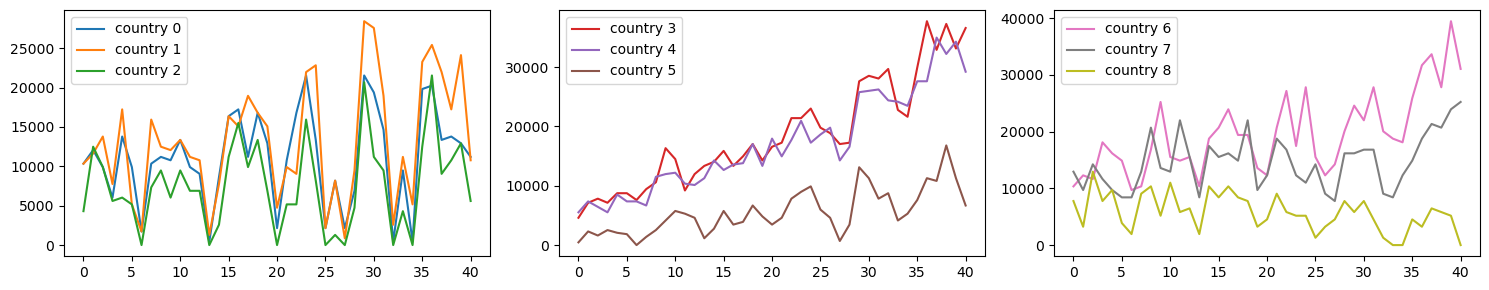

In [39]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True)
k = 0
for i in range(len(cluster_sizes)):
    for _ in range(cluster_sizes[i]):
        axs[i].plot(ZData_by_country[k], color=colors[k], label="country {}".format(k))
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

## Check that the objective function in non-increasing along the iterations

In [40]:
n_max_iter = 10

#init param
init_method = "U"
init_param = {"options":options, "lambdaU_pwlin": 20}

#optim param
lambda_Fro = 0.25
lambda_GR = 1.
lambda_pwlin = 20

save_objective = True

Z = ZData_by_country
max_iter = n_max_iter

ndep = Z.shape[0]
    
#handle param
Gregularization="L2"
dates = options["dates"]

lambda_GR = Rt_L.make_lambda_GR_as_list(max_iter, lambda_GR)

#initialize variables        
Restims = []
Lestims = []

if save_objective:
    ZDataNorm, ZPhiNorm = Rt_L.get_normalized_Zphi_and_Z(Z) # we compute once here. it will be usefull to compute the objective function at each iteration
objs = []
crits_R, crits_L = [], []
crits_R_true, crits_L_true = [], []


# initialize
R = Rt_L.initialize_alternate_optim(Z, ndep, options, init_method, init_param)
Restims.append(R)

L, crit_L_true = LL.learningL(lambda_GR[0], lambda_Fro, R, return_crit=True)
Lestims.append(L)

if save_objective:
    crit, _, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
    objs.append(crit)

for iter, lambda_gr in enumerate(lambda_GR[1:]):
    print(("    iteration {}/{}".format(iter+2, max_iter)))  

    #update R
    R, crit_R_true = RtM.Rt_with_laplacianReg(Z, L, lambda_pwlin, lambda_gr, Gregularization, dates, return_crit=True)
    if save_objective:
        _, _, crit_R = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
        crits_R.append(crit_R)
        crits_R_true.append(crit_R_true)

    # update L
    L, crit_L_true = LL.learningL(lambda_gr, lambda_Fro, R, return_crit=True)
    if save_objective:
        crit, crit_L, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
        objs.append(crit)
        crits_L.append(crit_L)
        crits_L_true.append(crit_L_true)
    
    Lestims.append(L)
    Restims.append(R)
# Restims, Lestims, _, objs, crits_R, crits_R_true, crits_L, crits_L_true = Rt_L.Rt_L(ZData_by_country, n_max_iter, lambda_pwlin, lambda_GR, lambda_Fro, options, init_method, init_param, save_objective=True)

Computing Univariate estimator ...
Done in 6.6048 seconds ---
    iteration 2/10
    iteration 3/10
    iteration 4/10
    iteration 5/10
    iteration 6/10
    iteration 7/10
    iteration 8/10
    iteration 9/10
    iteration 10/10


objective function at init : 82.88222233739653


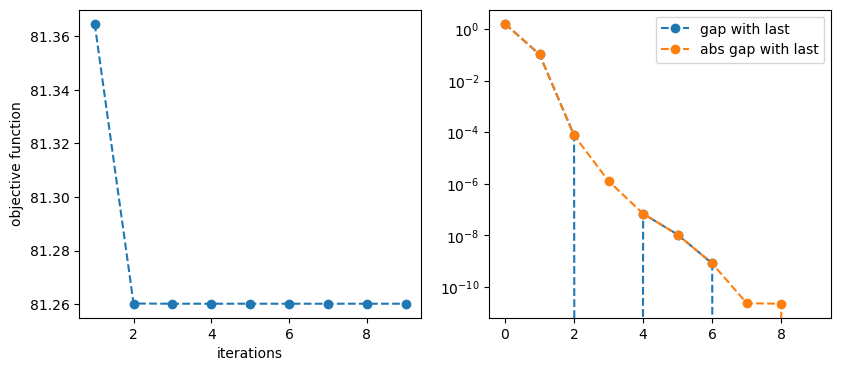

In [41]:
plt.figure(figsize=(15,4))

plt.subplot(131)
print("objective function at init : {}".format(objs[0]))
plt.plot(np.arange(1,max_iter), objs[1:], '--o')
plt.xlabel("iterations")
plt.ylabel("objective function")

plt.subplot(132)
plt.plot(np.arange(max_iter), objs-objs[-1], '--o', label="gap with last")
plt.plot(np.arange(max_iter), np.abs(objs-objs[-1]), '--o', label="abs gap with last")
plt.legend()
plt.yscale("log")

### Check that our computations are right
We verify that the way we compute the objective function matches with the objective function that are optimized in the alternate opimization procedure.

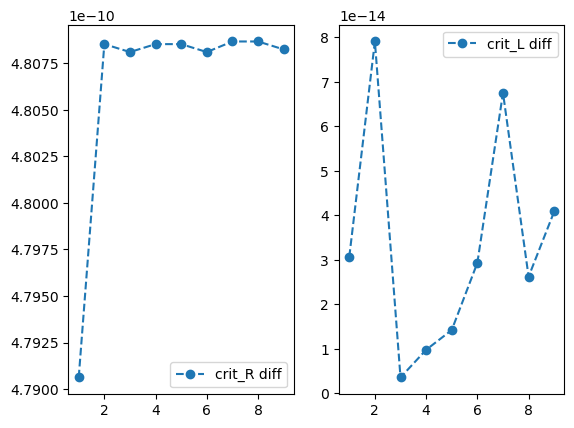

In [42]:
plt.subplot(121)
plt.plot(np.arange(1, n_max_iter), np.abs(np.array(crits_R)-np.array(crits_R_true)), '--o', label="crit_R diff" )
# plt.plot(np.arange(1, n_max_iter+1), crits_R_true, '-o', label="true crit_R" )
plt.legend()
plt.subplot(122)
plt.plot(np.arange(1, n_max_iter), np.abs(np.array(crits_L)-np.array(crits_L_true)), '--o', label="crit_L diff" )
# plt.plot(np.arange(1, n_max_iter+1), crits_L_true, '-o', label="true crit_L" )
plt.legend()

## Check various initializations

In [43]:
max_iter = 12

#init param
init_methods = ["U", "MLE", "UO"]
ninit = len(init_methods)
# init_methods = ["UO"]
# init_param = {"options":options, "lambdaU_pwlin": 20}

#optim param
lambda_Fro = 0.25
lambda_GR = 1.
lambda_pwlin = 20

Z = ZData_by_country

ndep = Z.shape[0]
    
#handle param
Gregularization="L2"
dates = options["dates"]

lambda_GR = Rt_L.make_lambda_GR_as_list(max_iter, lambda_GR)


ZDataNorm, ZPhiNorm = Rt_L.get_normalized_Zphi_and_Z(Z) # we compute once here. it will be usefull to compute the objective function at each iteration

objs_by_init = []
Lestims_by_init = []
Restims_by_init = []

for init_method in init_methods:

    print("Init method : {}".format(init_method))

    #initialize storage lists        
    Restims = []
    Lestims = []
    objs = []


    # initialize
    R = Rt_L.initialize_alternate_optim(Z, ndep, options, init_method)
    Restims.append(R)

    L = LL.learningL(lambda_GR[0], lambda_Fro, R)

    # L = - np.ones((ndep, ndep)) / (ndep-1)
    # np.fill_diagonal(L, 1)
    Lestims.append(L)

    crit, _, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
    objs.append(crit)

    for iter, lambda_gr in enumerate(lambda_GR[1:]):
        print(("    iteration {}/{}".format(iter+2, max_iter)))
        R = RtM.Rt_with_laplacianReg(Z, L, lambda_pwlin, lambda_gr, Gregularization, dates)
        L = LL.learningL(lambda_gr, lambda_Fro, R)
        crit, _, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
        objs.append(crit)
        Lestims.append(L)
        Restims.append(R)
    
    objs_by_init.append(objs)
    Lestims_by_init.append(Lestims)
    Restims_by_init.append(Restims)

Init method : U
Computing Univariate estimator ...
Done in 5.7401 seconds ---
    iteration 2/12
    iteration 3/12
    iteration 4/12
    iteration 5/12
    iteration 6/12
    iteration 7/12
    iteration 8/12
    iteration 9/12
    iteration 10/12
    iteration 11/12
    iteration 12/12
Init method : MLE
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
Computing Maximum Likelihood Estimator (MLE) ...
Done in 0.0000 seconds ---
    iter

obj function at init for U : 82.66308196650448
obj function at init for MLE : 1204.3868957206498
obj function at init for UO : 85.91069895061626


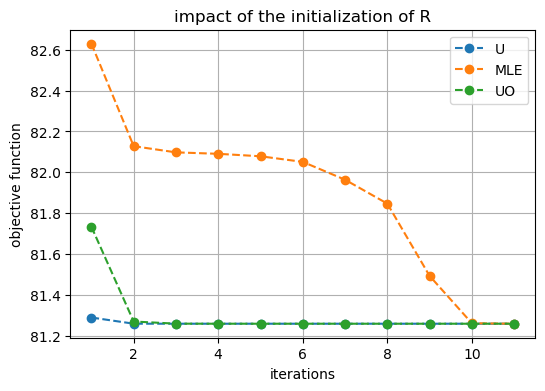

In [44]:
plt.figure(figsize=(6,4))

for i, init_method in enumerate(init_methods):
    print("obj function at init for {} : {}".format(init_method, objs_by_init[i][0]))
    plt.plot(np.arange(1, max_iter), objs_by_init[i][1:], '--o', label=init_method)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.title("impact of the initialization of R")
plt.grid()
plt.legend()

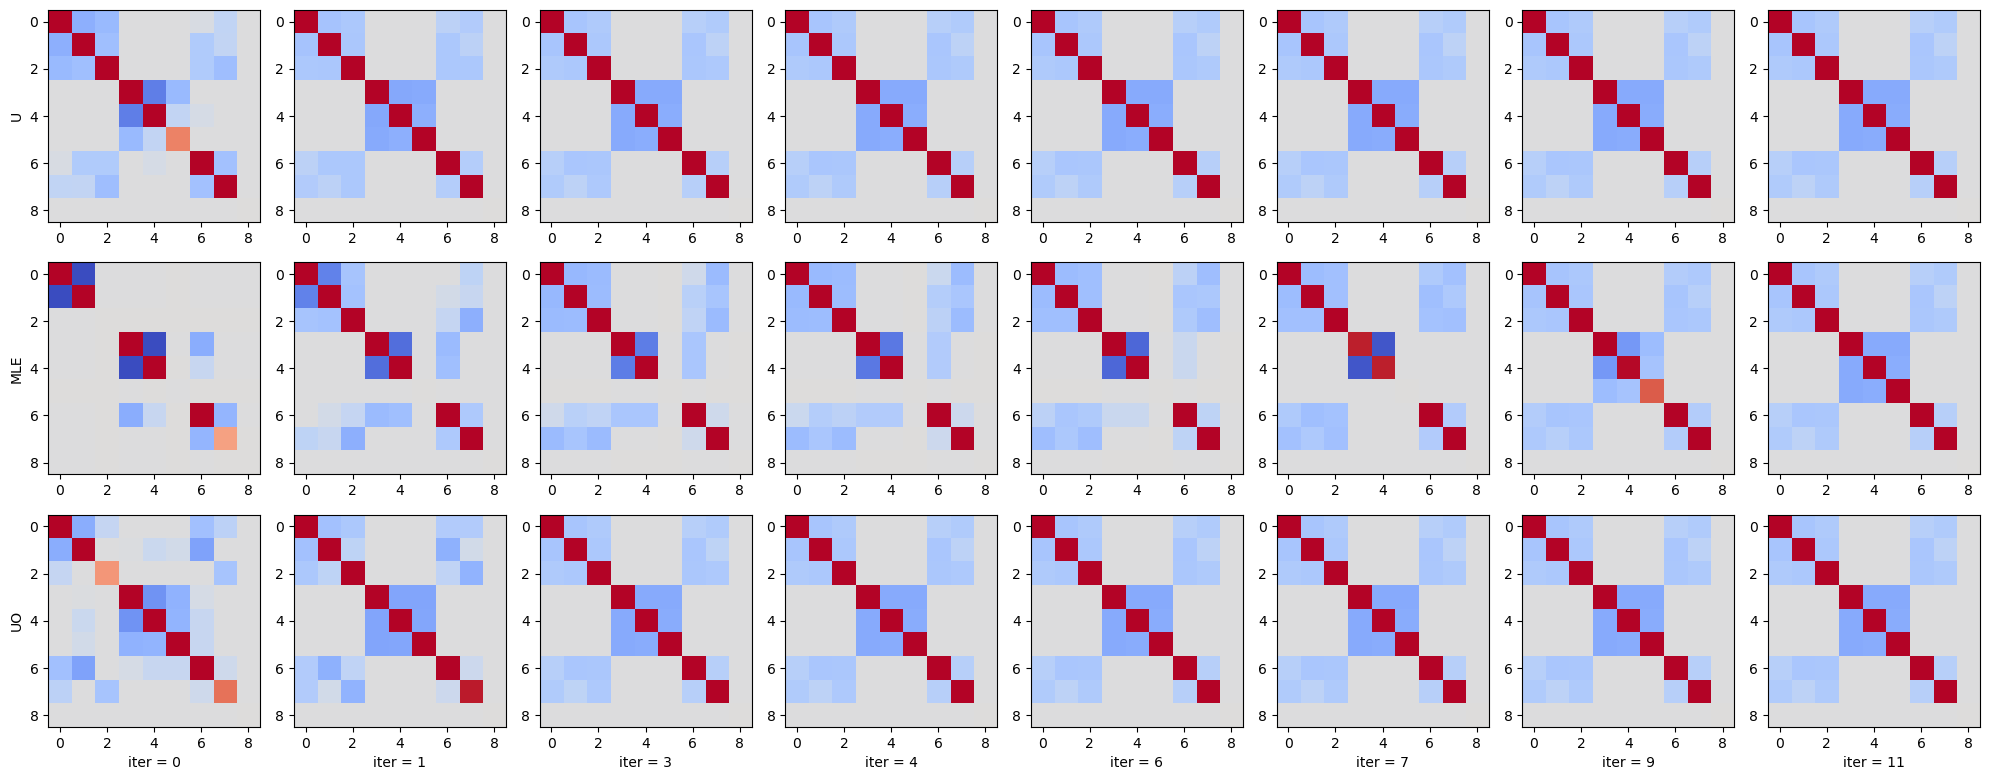

In [45]:
itermax = 15 # don't show after this iteration
itermax = min(itermax, max_iter-1)

nplot_max = 8
nplot = min(nplot_max, itermax)

ninit = len(init_methods)


fig, axs = plt.subplots(ninit, nplot, figsize=(20,4*len(init_method)), squeeze=False)
for i, init_method in enumerate(init_methods):
    axs[i][0].set_ylabel(init_method)
    for j in range(nplot):
        j_eff = int(j/(nplot-1)*(itermax))
        L, ax = Lestims_by_init[i][j_eff], axs[i][j]
        ax.imshow(L, cmap="coolwarm", vmin=-1, vmax=1)
        if i==ninit-1:
            ax.set_xlabel("iter = {}".format(j_eff))
plt.tight_layout()

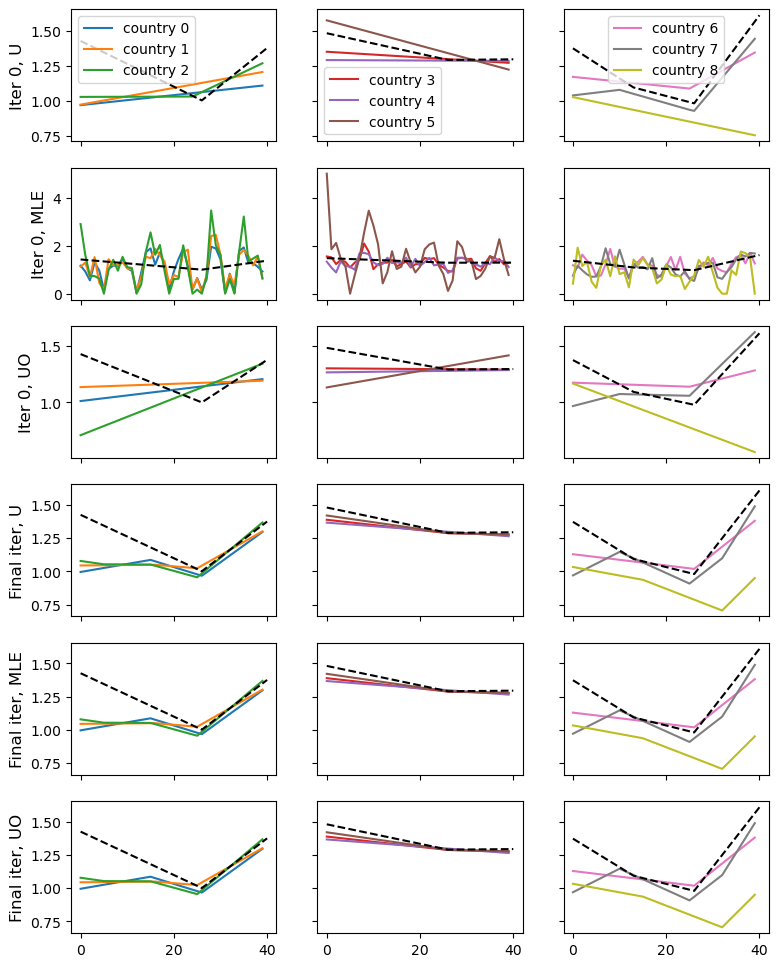

In [46]:
fig, axs = plt.subplots(2*ninit, nclusters, figsize=(3*nclusters,4*ninit), sharex=True, sharey="row", squeeze=False)
for i, init_method in enumerate(init_methods):
    k=0
    for j in range(nclusters):
        for _ in range(cluster_sizes[j]):
            axs[i,j].plot(Restims_by_init[i][0][k], color=colors[k], label="country {}".format(k))
            axs[i+ninit,j].plot(Restims_by_init[i][-1][k], color=colors[k], label="country {}".format(k))
            k+=1
        axs[i,j].plot(R_by_cluster[j], 'k--')
        axs[i+ninit,j].plot(R_by_cluster[j], 'k--')
        if i==0:
            axs[i,j].legend()
        if j==0:
            axs[i,j].set_ylabel("Iter 0, {}".format(init_method), fontsize=12)
            axs[i+ninit,j].set_ylabel("Final iter, {}".format(init_method), fontsize=12)
plt.show()

## Change initialization inside each R update (use previous R value)

In [47]:
n_max_iter = 5

#init param
init_method = "UO"

#optim param
lambda_Fro = 0.25
lambda_GR = 1.
lambda_pwlin = 20

save_objective = True

Z = ZData_by_country
max_iter = n_max_iter

ndep = Z.shape[0]
    
#handle param
Gregularization="L2"
dates = options["dates"]

lambda_GR = Rt_L.make_lambda_GR_as_list(max_iter, lambda_GR)

#initialize variables        
Restims, Lestims = [], []
Restims_si, Lestims_si = [], []

ZDataNorm, ZPhiNorm = Rt_L.get_normalized_Zphi_and_Z(Z) # we compute once here. it will be usefull to compute the objective function at each iteration
objs = [] 
objs_si = []

# initialize
Rsi = Rt_L.initialize_alternate_optim(Z, ndep, options, init_method)
Lsi = LL.learningL(lambda_GR[0], lambda_Fro, Rsi)
Restims.append(Rsi), Lestims.append(Lsi)
Restims_si.append(Rsi), Lestims_si.append(Lsi)
L = Lsi.copy()

crit, _, _ = Rt_L.obj_function(Rsi,Lsi,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
objs.append(crit)
objs_si.append(crit)

for iter, lambda_gr in enumerate(lambda_GR[1:]):
    print(("    iteration {}/{}".format(iter+2, max_iter)))  

    #update R,L
    ti = time()
    R = RtM.Rt_with_laplacianReg(Z, L, lambda_pwlin, lambda_gr, Gregularization, dates)
    tinter = time()
    L = LL.learningL(lambda_gr, lambda_Fro, R)
    tf = time()
    crit, _, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
    objs.append(crit)
    print("R update done in {:5.3}sec".format(tinter-ti))
    print("L update done in {:5.3}sec".format(tf-tinter))

    #update R,L si
    ti = time()
    Rsi = RtM.Rt_with_laplacianReg(Z, Lsi, lambda_pwlin, lambda_gr, Gregularization, dates, Rinit=Rsi)
    tinter = time()
    Lsi = LL.learningL(lambda_gr, lambda_Fro, Rsi)
    tf = time()
    crit_si, _, _ = Rt_L.obj_function(Rsi,Lsi,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
    objs_si.append(crit_si)
    print("Rsi update done in {:5.3}sec".format(tinter-ti))
    print("Lsi update done in {:5.3}sec".format(tf-tinter))
    
    Restims.append(R), Lestims.append(L)
    Restims_si.append(Rsi), Lestims_si.append(Lsi)
# Restims, Lestims, _, objs, crits_R, crits_R_true, crits_L, crits_L_true = Rt_L.Rt_L(ZData_by_country, n_max_iter, lambda_pwlin, lambda_GR, lambda_Fro, options, init_method, init_param, save_objective=True)

Computing Univariate estimation with O misreported counts modelisation ...
iter 100000.000000 	 crit=4.478853 

Done in 57.2629 seconds ---
    iteration 2/5
R update done in  14.7sec
L update done in 0.00209sec
Rsi update done in  14.1sec
Lsi update done in 0.00219sec
    iteration 3/5
R update done in  15.8sec
L update done in 0.00285sec
Rsi update done in  15.2sec
Lsi update done in 0.00185sec
    iteration 4/5
R update done in  14.6sec
L update done in 0.00184sec
Rsi update done in  14.4sec
Lsi update done in 0.00178sec
    iteration 5/5
R update done in  13.8sec
L update done in 0.00239sec
Rsi update done in  14.5sec
Lsi update done in 0.00177sec


objective function at init : 85.91069895061626


Text(0, 0.5, 'objective function')

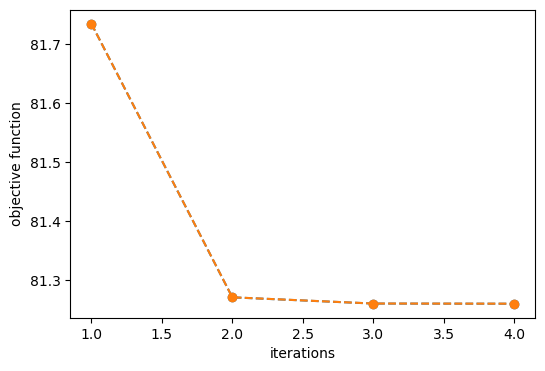

In [48]:
plt.figure(figsize=(6,4))

print("objective function at init : {}".format(objs[0]))
plt.plot(np.arange(1,max_iter), objs[1:], '--o', label="obj")
plt.plot(np.arange(1,max_iter), objs_si[1:], '--o', label="obj smart init")
plt.xlabel("iterations")
plt.ylabel("objective function")

## Try with more noise!

In [50]:
alpha = 0.5
ZData_by_country, ZData_by_cluster, R_by_cluster, O_by_cluster, options = generator.generate_synthZ(countries, cluster_sizes, firstDay, lastDay, alpha)

Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Computing Univariate estimation with O misreported counts modelisation ...
Done in 47.4340 seconds ---


First day : 2020-12-01 
 Last day : 2021-01-10


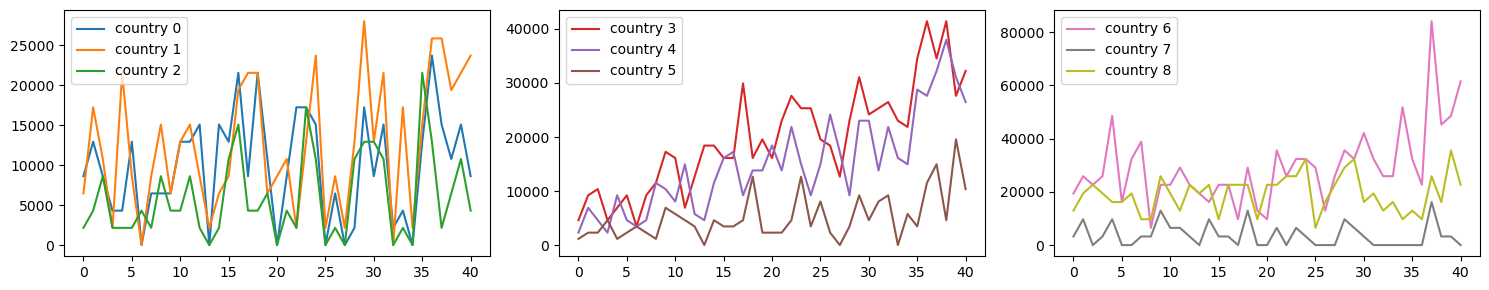

In [51]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True)
k = 0
for i in range(len(cluster_sizes)):
    for _ in range(cluster_sizes[i]):
        axs[i].plot(ZData_by_country[k], color=colors[k], label="country {}".format(k))
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

In [ ]:
n_max_iter = 10

#init param
init_method = "U"
init_param = {"options":options, "lambdaU_pwlin": 20}

#optim param
lambda_Fro = 0.25
lambda_GR = 1.
lambda_pwlin = 20

save_objective = True

Z = ZData_by_country
max_iter = n_max_iter

ndep = Z.shape[0]
    
#handle param
Gregularization="L2"
dates = options["dates"]

lambda_GR = Rt_L.make_lambda_GR_as_list(max_iter, lambda_GR)

#initialize variables        
Restims = []
Lestims = []

if save_objective:
    ZDataNorm, ZPhiNorm = Rt_L.get_normalized_Zphi_and_Z(Z) # we compute once here. it will be usefull to compute the objective function at each iteration
objs = []
crits_R, crits_L = [], []
crits_R_true, crits_L_true = [], []


# initialize
R = Rt_L.initialize_alternate_optim(Z, ndep, options, init_method, init_param)
Restims.append(R)

L, crit_L_true = LL.learningL(lambda_GR[0], lambda_Fro, R, return_crit=True)
Lestims.append(L)

if save_objective:
    crit, _, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
    objs.append(crit)

for iter, lambda_gr in enumerate(lambda_GR[1:]):
    print(("    iteration {}/{}".format(iter+2, max_iter)))  

    #update R
    R, crit_R_true = RtM.Rt_with_laplacianReg(Z, L, lambda_pwlin, lambda_gr, Gregularization, dates, return_crit=True)
    if save_objective:
        _, _, crit_R = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
        crits_R.append(crit_R)
        crits_R_true.append(crit_R_true)

    # update L
    L, crit_L_true = LL.learningL(lambda_gr, lambda_Fro, R, return_crit=True)
    if save_objective:
        crit, crit_L, _ = Rt_L.obj_function(R,L,ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR[-1], lambda_Fro)
        objs.append(crit)
        crits_L.append(crit_L)
        crits_L_true.append(crit_L_true)
    
    Lestims.append(L)
    Restims.append(R)
# Restims, Lestims, _, objs, crits_R, crits_R_true, crits_L, crits_L_true = Rt_L.Rt_L(ZData_by_country, n_max_iter, lambda_pwlin, lambda_GR, lambda_Fro, options, init_method, init_param, save_objective=True)